# Week 10/11 Homework
#### Moiya Josephs

## Ask

It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  [UCI Machine Learning Repository: Spambase Data Set](http://archive.ics.uci.edu/ml/datasets/Spambase)

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.


In [69]:
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np


In [27]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Data source: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets?resource=download

In [28]:
fakedf = pd.read_csv("Fake.csv")

In [29]:
fakedf.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [30]:
truedf = pd.read_csv("True.csv")
truedf.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Closer Look at the Data

Now I will look at the data to further understand the data set and construct the best algorithm.

<Axes: >

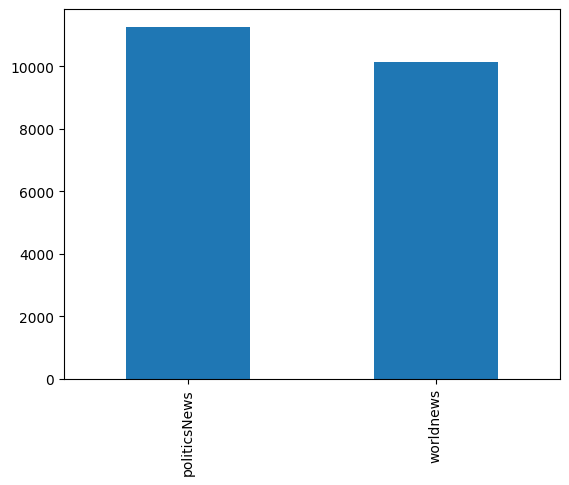

In [31]:
from collections import Counter

counts = Counter(truedf["subject"])
df_ver = pd.DataFrame.from_dict(counts, orient='index')
df_ver =  df_ver.sort_values(0, ascending = False)
df_ver.plot(kind = "bar", legend = False)

<Axes: >

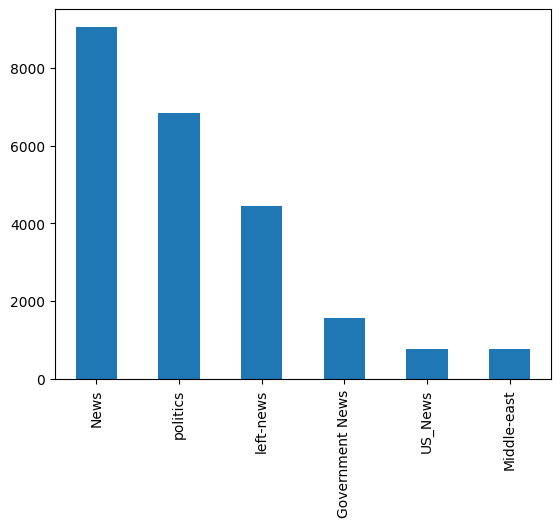

In [32]:
counts = Counter(fakedf["subject"])
df_ver = pd.DataFrame.from_dict(counts, orient='index')
df_ver =  df_ver.sort_values(0, ascending = False)
df_ver.plot(kind = "bar", legend = False)

The fake news dataset has different subjects than the true news dataset.

## Preparing Data for Classification

In order to classify each news article as fake or true, I needed to add the labels for each. The datasets given in Kaggle are split by these labels. In order to apply the models, I will add a label column indicating true or fake and then combine the datasets.

If a news article is "fake news" it will be indicated with a 1, if the news article is true then it will be indicated with a 0.

In [52]:
# Labeling text
fakedf['label'] = 1
truedf['label'] = 0

# Combining the datasets
df = pd.concat([truedf,fakedf])
df = pd.concat([truedf,fakedf])
df.drop(["subject",'title','date'],axis=1,inplace=True)
random_indexes = np.random.randint(0,len(df),len(df))
news = df.iloc[random_indexes].reset_index(drop=True)

Checking the total dataset for null values.

In [54]:
news.isnull().sum()


text     0
label    0
dtype: int64

There are no missing values in this dataset, so I can proceed with the rest of the data preparation.

To prepare, I will remove the unnecessary rows from the dataset. First I will determine if the classifiers will bettee classify fake or true news from based on the title or the text in the news article.

#### Length of Texts

(0.0, 20000.0)

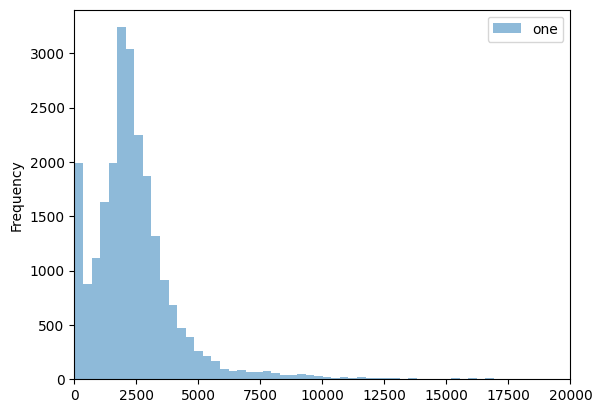

In [36]:
fake_len = []
for text in fakedf["text"]:
  fake_len.append(len(text))

df = pd.DataFrame(fake_len, columns=['one'])
ax = df.plot.hist(bins=150, alpha=0.5)
ax.set_xlim(0,20000)

(0.0, 10000.0)

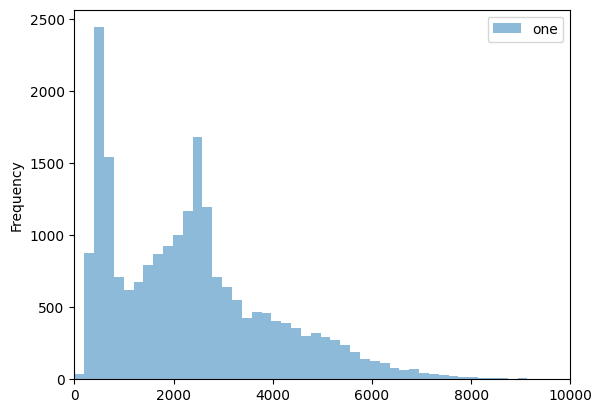

In [37]:
true_len = []
for text in truedf["text"]:
  true_len.append(len(text))

df = pd.DataFrame(true_len, columns=['one'])
ax = df.plot.hist(bins=150, alpha=0.5)
ax.set_xlim(0,10000)


Fake news has a wider distribution and longer length of texts compared to the true news dataset.

## Preprocess Text Data

Below I preprocess the data for classification by making all the words lower case and tokenizing the texts. Additionally, I will remove the stop words from the text so that the classifier can better differentiate between fake and true news.

In [55]:

# Preprocess text data
news["text"] = news["text"].str.lower()
news["text"] = news["text"].apply(word_tokenize)
stop_words = set(stopwords.words("english"))
news["text"] = news["text"].apply(lambda x: [word for word in x if word not in stop_words])
news["text"] = news["text"].apply(lambda x: " ".join(x))

## Feature Extraction

To perform feature extraction I will compare different vectorizers. Then I will split the data set and apply different classifiers and test the accuracy for each.

### Count Vectorizer

In [70]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(news["text"])

X_train, X_test, y_train, y_test = train_test_split(X, news["label"], test_size=0.2, random_state=42)


#### Multinomial Naive Bayes Classifier

In [71]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9615812917594655
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4221
           1       0.97      0.96      0.96      4759

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



In [72]:
classifier = PassiveAggressiveClassifier(max_iter=10)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9963251670378619
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4221
           1       1.00      1.00      1.00      4759

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


### Tfidf Vectorizer


Now I will use the `Tfdif Vectorizer` to extract defining characteristics to classify the documents.  

TF (Term Frequency): The number of times a word appears in a document is its Term Frequency. A higher value means a term appears more often than others, and so, the document is a good match when the term is part of the search terms.

IDF (Inverse Document Frequency): Words that occur many times a document, but also occur many times in many others, may be irrelevant. IDF is a measure of how significant a term is in the entire corpus.

The `TfidfVectorizer` converts a collection of raw documents into a matrix of TF-IDF features.

In [73]:
#Feature Extraction
vectorizer=TfidfVectorizer()
X = vectorizer.fit_transform(news["text"])

#Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, news["label"], test_size=0.2, random_state=42)


#### Multinomical Naive Bayes

In [74]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9451002227171492
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4221
           1       0.95      0.95      0.95      4759

    accuracy                           0.95      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.95      0.95      0.95      8980



#### Passive Aggressive Classifier

The Passive Aggressive algorithms remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. It updates and corrects based on errors.

In [76]:
classifier = PassiveAggressiveClassifier(max_iter=100)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9979955456570155
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4221
           1       1.00      1.00      1.00      4759

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



## Conclusion

The Passive Agrresive Classifier performed the best based on accuracy but the 100% result may be due to underfitting or improper tuning of the vectorizer. If I were to move forward with this project, I would implement the Multinomical Naive Bayes classifier with the Tfdif vectorizer. The accuract was able to predict to a 95% accuracy,